In [1]:
import numpy as np
from numpy import linalg as la
import gmpy2
import matplotlib.pyplot as plt
import scipy.optimize as opt

T = 1

def lamb() -> float:
    """Common ratio parameter"""
    return 2.0


def int_w():
    return np.power(lamb(), np.linspace(-1, 1, 100))


def int_epsilon():
    i = int(np.log(np.power(10, 5)/np.log(np.power(lamb(), 2))))
    return np.power(10, np.linspace(1, -5, i)), np.power(10, np.linspace(1, -5, 101))


def find_E():
    ns = []
    for i in range(len(int_epsilon()[0])):
        a = int(-np.log(0.1*int_epsilon()[0][i])/np.log(lamb()))
        if a % 2 == 0:
            continue
        ns.append(a)
    return ns


def int_ws():
    theta = np.linspace(-0.5, 0.5, 20)
    w = []
    for i in range(len(theta)):
        w.append(np.power(lamb(), theta[i]))
    return w


def zeta():
    """" returns offset """
    return 0


def t_n(n, w):
    """Hopping energy of eNRG parametrization: n = number of states"""

    return T / w * np.power(lamb(), -n - 1 / 2)



def normaliz(n, w):
    """returns RG renormalization factor, equal to smallest codiagonal element"""
    return t_n(n - 2, w)


def dig_ham(n, k, w):
    """Hamiltonian: n(odd) = Matrix Dimension / k = scattering potential"""
    if n % 2 == 0:
        print("Sorry: n must be odd")
        exit(1)

    if zeta() == 0:
        ham__ = np.zeros((n + 1, n + 1))
        ham__[0][0] = k
        ham__[0][1] = ham__[1][0] = T / np.sqrt(w)
        for i in range(1, (n + 1) - 1):
            ham__[i][i + 1] = ham__[i + 1][i] = t_n(i - 1, w)
        eval_, evec__ = la.eigh(ham__)
        return eval_, evec__.T, eval_ / normaliz(n, w)

    else:
        """returns Hamiltonian with offset"""
        ham__ = np.zeros((n + 1, n + 1))
        ham__[0][0] = k
        for i in range(1, zeta() + 1):
            ham__[i-1][i] = ham__[i][i-1] = T
        for i in range(zeta(), (n + 1) - 1):
            ham__[i][i + 1] = ham__[i + 1][i] = t_n(i - (1+zeta()), w)
        eval_, evec__ = la.eigh(ham__)
        return eval_, evec__.T, eval_ / normaliz(n, w), ham__


def delta(n, k, w):
    """"returns phase shift / pi associated with potential scattering k"""
    ene0_ = dig_ham(n, 0, w)[2]
    ene_ = dig_ham(n, k, w)[2]
    nfermi3: int = int((n + 1) / 2 + 3)
    ret = np.log(ene_[nfermi3] / ene0_[nfermi3]) / np.log(np.power(lamb(), 2.0))

    return ret


def xps_proj(n, k, w, hole, head):
    """Determinant of a projection of the final state over the initial: n = number of electrons in the conduction band
    hole = hole state below Fermi's level / head = particle state above Fermi's level / k = scattering potential"""
    nfermi = int((n + 1) / 2)
    mel = np.zeros((nfermi, nfermi))
    evali, eveci__, adm_eneri_ = dig_ham(n, 0, w)
    evalf, evecf__, adm_enerf_ = dig_ham(n, k, w)
    for bra in range(nfermi):
        for ket in range(nfermi):
            if bra == hole:
                mel[bra][ket] = np.dot(evecf__[head], eveci__[ket])
            if bra < nfermi and bra != hole:
                mel[bra][ket] = np.dot(evecf__[bra], eveci__[ket])
    ener_excit = evalf[head] - evalf[hole]
    ener_norm = ener_excit / normaliz(n, w)
    return ener_excit, np.power(la.det(mel), 2), ener_norm


def spectrum(ni, nf, k, w, head):
    """"compute xps rates for a logarithmic sequence of energies of a fixed head"""
    n_erg: int = int((nf - ni) / 2)
    erg_ = np.zeros((n_erg))
    rate_ = np.zeros_like(erg_)
    erg_norm_ = np.zeros_like(rate_)

    count = 0
    for n in range(ni, nf, 2):
        nfermi = int((n + 1) / 2)
        n_hole = nfermi - head
        n_excit = nfermi + head - 1
        erg_[count], rate_[count], erg_norm_[count] = xps_proj(n, k, w, n_hole, n_excit)
        count += 1
    return erg_, rate_


def spectrum_sec(ni, nf, k, w, head):
    """"compute secondary xps rates for a logarithmic sequence of energies above a fixed head"""
    erg_sec_ = np.zeros((int((nf-ni)/2)*np.power(head - 1, 2)))
    rate_sec_ = np.zeros_like(erg_sec_)
    erg_sec_norm_ = np.zeros_like(erg_sec_)

    count = 0
    for n in range(ni, nf, 2):
        nfermi = int((n + 1) / 2)
        n_hole = nfermi - head
        n_excit = nfermi + head - 1
        for j in range(n_hole + 1, nfermi):
            for u in range(nfermi, n_excit):
                erg_sec_[count], rate_sec_[count], erg_sec_norm_[count] = xps_proj(n, k, w, j, u)
                count += 1
    return erg_sec_, rate_sec_


def convolution(ni, nf, k, w, head):
    """compute xps rate with a convolution with a box function"""
    erg_, rate_ = spectrum(ni, nf, k, w, head)
    erg_sec_, rate_sec_ = spectrum_sec(ni, nf, k, w, head)
    erg_conv_ = np.zeros(len(rate_)-2)
    rate_conv_ = np.zeros_like(erg_conv_)
    soma = np.zeros(len(erg_)-2)
    for i in range(len(erg_)-2):
        for j in range(len(erg_sec_)):
            if np.sqrt(erg_[i+1]*erg_[i+2]) < erg_sec_[j] < np.sqrt(erg_[i]*erg_[i+1]):
                soma[i] += rate_sec_[j]
        rate_conv_[i] = (soma[i] + rate_[i+1]) / np.power(np.log(np.power(lamb(), 2)), 1)
        erg_conv_[i] = erg_[i+1]
    return erg_conv_, rate_conv_


def binarystates(n, head, nex):
    """List of every possible state for a number n"""
    nfermi = int((n+1)/2)
    decimal_states_ = []
    for i in range(2**(n+1)):
        nn = gmpy2.mpz(i)
        if gmpy2.popcount(nn) == nfermi:
            decimal_states_.append(nn)
    l = len(decimal_states_)
    filled__ = np.zeros((l, nfermi))
    excl = []
    list = []
    for j in range(l):
        count = 0
        for k in range(nfermi):
            level = gmpy2.bit_scan1(decimal_states_[j], count)
            filled__[j][k] = level
            count = level + 1
    for i in range(1, len(filled__)): #é um caso que considera mais de uma excitação PH limitado pelo head
        for j in range(nfermi):
            if j < nfermi - head and filled__[i][j] != filled__[0][j]:
                list.append(i)
            if j > nfermi - head and filled__[i][j] > nfermi + 2:
                list.append(i)

        search = 0
        for k in range(nfermi):
            if filled__[i][k] > nfermi - 1:
                search += 1
            if search > nex:
                excl.append(i)
                search = 0

    return np.delete(filled__, excl, 0), np.delete(filled__, list+excl, 0)


def xps_proj_binary(n, k, w, bs__):
    """compute all the xps ray (primary and secondary) for states in binary form"""
    evali, eveci__, adm_eneri_ = dig_ham(n, 0, w)
    evalf, evecf__, adm_enerf_ = dig_ham(n, k, w)
    nfermi = int((n + 1) / 2)
    rate_ = np.zeros(len(bs__)-1)
    erg_ = np.zeros(len(bs__)-1)
    sum_hole = 0
    for i in range(nfermi):
        ener_hole = evalf[int(bs__[0][i])]
        sum_hole += ener_hole
    for state in range(1, len(bs__)):
        mel = np.zeros((nfermi, nfermi))
        sum_excit = 0
        for bra in range(nfermi):
            for ket in range(nfermi):
                mel[bra][ket] = np.dot(evecf__[int(bs__[state][bra])], eveci__[int(bs__[0][ket])])
            ener_excit = evalf[int(bs__[state][bra])]
            sum_excit += ener_excit
        erg_[state-1] = sum_excit - sum_hole
        rate_[state-1] = np.power(la.det(mel), 2)
    return erg_, rate_

def binary_convolution_head(ni, nf, k, w, head):
    """compute all the xps ray for states in binary form with a convolution box function"""
    erg_, rate_ = spectrum(ni, nf, k, w, head)
    rate_conv_ = np.zeros(len(erg_) - 2)
    erg_conv_ = np.zeros_like(rate_conv_)
    for n in range(ni, nf, 2):
        woh__, wh__ = binarystates(n, head, 2)
        ergs_, rates_ = xps_proj_binary(n, k, w, wh__)
        for i in range(len(erg_) - 2):
            for j in range(len(ergs_) - 2):
                if np.sqrt(erg_[i + 1] * erg_[i + 2]) < ergs_[j] < np.sqrt(erg_[i] * erg_[i + 1]):
                    rate_conv_[i] += rates_[j]
                    erg_conv_[i] = erg_[i+1]
    return erg_conv_, rate_conv_ / (np.log(np.power(lamb(), 2)))

def binary_convolution(k):
    """compute all the xps ray for states in binary form with a convolution box function: max 2 P-H"""
    rate_conv_ = []
    erg_conv_ = []
    erg__ = []
    rate__ = []
    for i in range(len(find_E())):
        woh__, wh__ = binarystates(find_E()[i], 0, 2)
        for j in range(len(int_ws())):
            ergs_, rates_ = xps_proj_binary(find_E()[i], k, int_ws()[j], woh__)
            for p in range(len(ergs_)):
                erg__.append(ergs_[p])
                rate__.append(rates_[p])
        s = 0
        for r in range(10*i, 10*(i+1)):
            for h in range(len(erg__)):
                if int_epsilon()[1][r] > erg__[h] > int_epsilon()[1][r+1]:
                    s += rate__[h]
            rate_conv_.append(s)
            
    for l in range(len(int_epsilon()[1])-1):
        erg_conv_.append(np.sqrt(int_epsilon()[1][l]*int_epsilon()[1][l+1]))

    return erg_conv_, rate_conv_


def dig_ham_imp(n, k, d, v, w):
    """Hamiltonian: n(odd) = Matrix Dimension / k = scattering potential / v = impurity bounding energy"""
    if n % 2 == 0:
        print("Sorry: n must be odd")
        exit(1)

    else:
        ham__ = np.zeros((n + 1, n + 1))
        ham__[0][0] = d
        ham__[1][1] = k
        ham__[1][2] = ham__[2][1] = T / np.sqrt(w)
        ham__[0][1] = ham__[1][0] = v
        for i in range(2, (n + 1) - 1):
            ham__[i][i + 1] = ham__[i + 1][i] = t_n(i - 2, w)
        eval_, evec__ = la.eigh(ham__)
        return eval_, evec__.T, eval_ / normaliz(n, w)


def xps_proj_imp(n, k, d, v, w, hole, excit):
    """Determinant of a projection of the final state over the initial: ne = number of electrons in the conduction band
    hole = hole state below Fermi's level / excit = particle state above Fermi's level / k = scattering potential"""
    nfermi = int((n + 1) / 2)
    mel = np.zeros((nfermi, nfermi))
    evali, eveci__, adm_eneri_ = dig_ham_imp(n, 0, d, v, w)
    evalf, evecf__, adm_enerf_ = dig_ham_imp(n, k, d, v, w)
    for bra in range(n):
        for ket in range(nfermi):
            if bra == hole:
                mel[bra][ket] = np.dot(evecf__[excit], eveci__[ket])
            if bra < nfermi and bra != hole:
                mel[bra][ket] = np.dot(evecf__[bra], eveci__[ket])
    ener_excit = evalf[excit] - evalf[hole]
    return ener_excit, np.power(la.det(mel), 2)


def spectrum_imp(ni, nf, k, d, v, w, head):
    """"compute xps rates for a logarithmic sequence of energies of a fixed head"""
    n_erg: int = int((nf - ni) / 2)
    erg_imp_ = np.zeros((n_erg))
    rate_imp_ = np.zeros_like(erg_imp_)

    count = 0
    for n in range(ni, nf, 2):
        nfermi = int((n + 1) / 2)
        n_hole = nfermi - head
        n_excit = nfermi + head - 1
        erg_imp_[count], rate_imp_[count] = xps_proj_imp(n, k, d, v, w, n_hole, n_excit)
        count += 1
    return erg_imp_, rate_imp_


def xps_proj_imp_binary(n, k, d, v, w, bs__):
    """compute all the xps ray (primary and secondary) for states in binary form"""
    evali, eveci__, adm_eneri_ = dig_ham_imp(n, 0, d, v, w)
    evalf, evecf__, adm_enerf_ = dig_ham_imp(n, k, d, v, w)
    nfermi = int((n + 1) / 2)
    rate_imp_ = np.zeros(len(bs__)-1)
    erg_imp_ = np.zeros(len(bs__)-1)
    sum_hole = 0
    for i in range(nfermi):
        ener_hole = evalf[int(bs__[0][i])]
        sum_hole += ener_hole
    for state in range(1, len(bs__)):
        mel = np.zeros((nfermi, nfermi))
        sum_excit = 0
        for bra in range(nfermi):
            for ket in range(nfermi):
                mel[bra][ket] = np.dot(evecf__[int(bs__[state][bra])], eveci__[int(bs__[0][ket])])
            ener_excit = evalf[int(bs__[state][bra])]
            sum_excit += ener_excit
        erg_imp_[state-1] = sum_excit - sum_hole
        rate_imp_[state-1] = np.power(la.det(mel), 2)
    return erg_imp_, rate_imp_


def binary_convolution_imp(n, k, d, v):
    """compute all the xps ray for states in binary form with a convolution box function"""
    woh__, wh__ = binarystates(n, 3, 2)
    rate_conv_ = []
    erg_conv_ = []
    erg__ = []
    rate__ = []
    for i in range(len(int_ws())):
        ergs_, rates_ = xps_proj_imp_binary(n, k, d, v, int_ws()[i], woh__)
        for j in range(len(ergs_)):
            erg__.append(ergs_[j])
            rate__.append(rates_[j])
    for p in range(len(int_epsilon()) - 1):
        erg_conv_.append(np.sqrt(int_epsilon()[p] * int_epsilon()[p + 1]))
        s = 0
        for h in range(len(erg__)):
            if int_epsilon()[p] > erg__[h] > int_epsilon()[p + 1]:
                s += rate__[h]
        rate_conv_.append(s)
    return erg_conv_, rate_conv_

def inside(ni, nf, k, d, v, head):
    es = []
    ws = []
    eps = []
    erg_, rate_ = spectrum_imp(ni, nf, k, d, v, 2, head)
    dw = 1 / np.power(10, 7)
    iw = int_w() + dw
    for i in range(len(int_epsilon())):
        for p in range(len(int_w()) - 1):
            for j in range(len(erg_)):
                if (spectrum_imp(ni, nf, k, d, v, int_w()[p], head)[0][j] - int_epsilon()[i]) * (
                        spectrum_imp(ni, nf, k, d, v, int_w()[p + 1], head)[0][j]
                        - int_epsilon()[i]) < 0:
                    es.append(j)
                    ws.append(p)
                    eps.append(int_epsilon()[i])
    erg_w_ = np.zeros(len(es))
    rate_w_ = np.zeros(len(es))
    for i in range(len(es)):
        erg_w_[i] = eps[i]
        rate_w_[i] = spectrum_imp(ni, nf, k, d, v, int_w()[ws[i]], head)[1][es[i]]
    return erg_w_, rate_w_

a_0 = 1/(2*np.sqrt(lamb()))*((1-np.power(lamb(), -2))/(1+np.power(lamb(), -2))) * (1 + (np.power(lamb(),-4))/(np.power(1+np.power(lamb(),-2),2)))

In [10]:
def zeta():
    """" returns offset """
    return 0
def lamb() -> float:
    """Common ratio parameter"""
    return 2.0
print(find_E())
print(int_epsilon()[0])
print(int_epsilon()[1])

[11, 11, 11, 11, 11, 11]
[1.0000e-03 2.0008e+00 4.0006e+00 6.0004e+00 8.0002e+00 1.0000e+01]
[0.001, 0.0212, 0.0414, 0.0616, 0.0818, 0.102, 0.1222, 0.1424, 0.1626, 0.1828, 0.20299999999999999, 0.22319999999999998, 0.2434, 0.2636, 0.2838, 0.304, 0.3242, 0.3444, 0.3646, 0.3848, 0.40499999999999997, 0.42519999999999997, 0.44539999999999996, 0.46559999999999996, 0.4858, 0.506, 0.5262, 0.5464, 0.5666, 0.5868, 0.607, 0.6272, 0.6474, 0.6676, 0.6878, 0.708, 0.7282, 0.7484, 0.7686, 0.7888, 0.8089999999999999, 0.8291999999999999, 0.8493999999999999, 0.8695999999999999, 0.8897999999999999, 0.9099999999999999, 0.9301999999999999, 0.9503999999999999, 0.9706, 0.9908, 1.011, 1.0312, 1.0514, 1.0715999999999999, 1.0917999999999999, 1.1119999999999999, 1.1321999999999999, 1.1523999999999999, 1.1725999999999999, 1.1927999999999999, 1.2129999999999999, 1.2331999999999999, 1.2533999999999998, 1.2735999999999998, 1.2937999999999998, 1.3139999999999998, 1.3341999999999998, 1.3543999999999998, 1.3745999999999

In [43]:
def zeta():
    """" returns offset """
    return 3
def lamb() -> float:
    """Common ratio parameter"""
    return 2.0
e_2_3_1, r_2_3_1 = binary_convolution(-1)

In [44]:
def zeta():
    """" returns offset """
    return 4
def lamb() -> float:
    """Common ratio parameter"""
    return 2.0
e_2_4_1, r_2_4_1 = binary_convolution(-1)

In [56]:
a = []
b = []
for i in range(len(e_2_3_1)):
    a.append((e_2_3_1[i]+e_2_3_1[i])/2)
    b.append((r_2_4_1[i]+r_2_4_1[i])/2)

In [16]:
def zeta():
    """" returns offset """
    return 3
def lamb() -> float:
    """Common ratio parameter"""
    return 2.0
e_2_3_5, r_2_3_5 = binary_convolution(-5)

In [17]:
def zeta():
    """" returns offset """
    return 4
def lamb() -> float:
    """Common ratio parameter"""
    return 2.0
e_2_4, r_2_4 = binary_convolution(-5)

In [18]:
c = []
d = []
for i in range(len(e_2_3_5)):
    c.append((e_2_3_5[i]+e_2_3_5[i])/2)
    d.append((r_2_4[i]+r_2_4[i])/2)

In [31]:
f = open("plot_K=-5", "x")
f = open("plot_K=-5", "a")
for i in range(len(a)):
     f.write(str(a[i])+" "+str(b[i])+"\n")
f.close()

[]

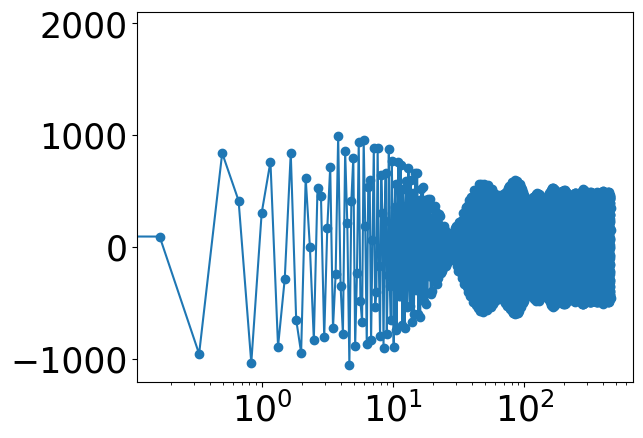

In [232]:
trans = np.fft.rfft(np.array(b))
tim = np.fft.rfftfreq(len(a), abs(a[1]-a[2]))

plt.plot(tim, trans, '-o', label=r'$\zeta = 3 ,4 , \lambda = 2$')
plt.semilogx()
#plt.ylim(-40,40)
#plt.xlim(0.1, 20)


[]

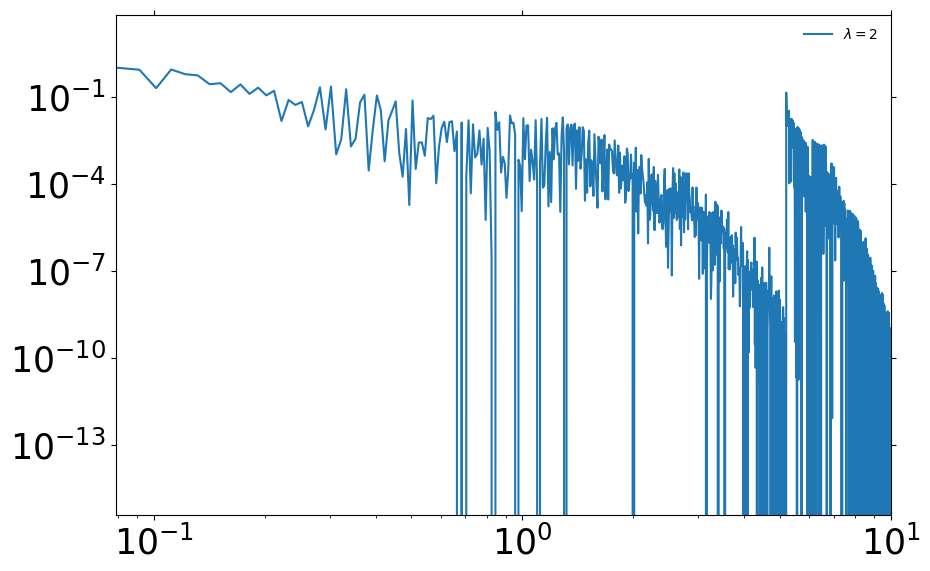

In [19]:
linha=3
plt.figure(figsize=(10,6.5)) 
plt.tick_params(bottom=True, top=True, left=True, right=True, labelsize=25)


#plt.plot(np.array(a), np.array(b)/np.array(a), '-', label=r'$\lambda = 2$')
plt.plot(np.array(c), np.array(d)/np.array(c), '-', label=r'$\lambda = 2$')


#plt.ylabel(r'$D_n$')
plt.xlim(0.079,10)
#plt.ylim(0,1)
#plt.axhline(y=assim,color="gray",linewidth=2)
#plt.xlabel(r"$t$")
#plt.axhline(y = assim, color = 'gray', linestyle = '--') 
plt.rcParams.update({'font.size': 25})
plt.legend(ncol=5,prop={'size':10}, loc='upper right',frameon=False)
#plt.tick_params(direction='in', length=6, width=2, colors='black',grid_color='r', grid_alpha=0.5)
#plt.title(r'$K=-5$', fontsize=30)
#plt.semilogx()
plt.loglog()